In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sys

sys.path.insert(0,'..')
%matplotlib inline

/Users/d3sm0/.virtualenvs/ntsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from train import Trainer
from utils.misc import Logger
from base import RNN, InputAttention

from utils.dataset_utils import (load_data,train_test_split, make_features)
from dataset import Dataset

## Input attention

As in [DARNN](https://arxiv.org/pdf/1704.02971.pdf) the input attention is designed to focus on raw features of the k dimensional input of the time series. Given a cell hidden state $h_{t-1}$ and the series features $x_{t-1}$, attention is computed as a deterministic filter, for example a dense layer with output shape of 1, applied to the all batch and the last hidden state of the cell.

$$e_t^k = W(h_{t-1} + x^k) + b$$

Then we can normalize the weights using a softmax function:

$$\alpha_t^k = softmax(e_t^k)$$

And compute the candidate output, $\widetilde{x}$ as:

$$\widetilde{x_t} = \alpha_t \odot x_t $$

In [119]:
path= "../tf/rnn/woc-2018-09-21-02-06-21"

In [4]:
config = Logger.get_config(path)

In [95]:
df = load_data(config.dataset)

In [96]:
features = df.columns.tolist()
features

['temperature_habitacion_sensor',
 'temperature_comedor_sensor',
 'weather_temperature',
 'co2_comedor_sensor',
 'co2_habitacion_sensor',
 'humedad_comedor_sensor',
 'humedad_habitacion_sensor',
 'lighting_comedor_sensor',
 'lighting_habitacion_sensor',
 'precipitacion',
 'meteo_exterior_crepusculo',
 'meteo_exterior_viento',
 'meteo_exterior_sol_oest',
 'meteo_exterior_sol_est',
 'meteo_exterior_sol_sud',
 'meteo_exterior_piranometro',
 'temperature_exterior_sensor',
 'humedad_exterior_sensor',
 'day_of_week']

In [16]:
x, index, stats = make_features(df, 
                                seq_len=config.seq_len, 
                                preprocess=config.preprocess,
                                lags=config.lags, 
                                use_x=config.use_x,
                               )

In [17]:
dataset = Dataset(x, index,stats, seq_len=config.seq_len, pred_len=config.pred_len,random_start=True)

INFO:tensorflow:Dataset loaded. Total Batches: 4113


In [18]:
it = dataset.__iter__()

In [19]:
feeds, dates = next(it)

In [20]:
tf.reset_default_graph()

In [21]:
model = RNN(dataset.shape, config=config)

In [22]:
trainer = Trainer(model, config=config, path=path)

INFO:tensorflow:Built model with scope rnn


In [23]:
trainer.init_sess()

In [24]:
trainer.restore(path=path)

INFO:tensorflow:Restoring parameters from ../tf/rnn/woc-2018-09-21-02-06-21/model/-99447


In [25]:
sess =trainer.sess

In [26]:
sess.run(tf.global_variables_initializer())

In [27]:
tf.trainable_variables()

[<tf.Variable 'rnn/encoder/input_attention/memory/kernel:0' shape=(76, 1) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/input_attention/memory/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/gates/kernel:0' shape=(82, 128) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/gates/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/candidate/kernel:0' shape=(82, 64) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/candidate/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/fc/kernel:0' shape=(64, 1) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/fc/bias:0' shape=(1,) dtype=float32_ref>]

In [29]:
h = model.x

In [30]:
attn = InputAttention(output_shape=1, memory=h, name='rnn/encoder/input_attention', use_bias=True)

In [32]:
state = tf.zeros(shape=(8, config.encoder), dtype=tf.float32)

In [33]:
t = 0 

In [34]:
x_tilde = attn.apply(h[:, t,:], state)

In [35]:
feed_dict = trainer._get_dict(feeds)

### First timestep, first batch of random day

In [47]:
features.pop(0)

'temperature_habitacion_sensor'

In [53]:
alpha = trainer.sess.run(x_tilde, feed_dict)

In [54]:
alpha = alpha.mean(axis=0).reshape((1,-1))

In [55]:
# features importance for each a single sequence at time 0
df = pd.DataFrame(alpha, columns=features)

In [65]:
mif = df[df>0].fillna(0)
mif.mean(axis=0).sort_values(ascending=False)

lighting_comedor_sensor        0.434782
meteo_exterior_piranometro     0.305990
lighting_habitacion_sensor     0.133677
meteo_exterior_crepusculo      0.064929
meteo_exterior_viento          0.055221
temperature_exterior_sensor    0.054266
meteo_exterior_sol_sud         0.045617
weather_temperature            0.045214
meteo_exterior_sol_est         0.017678
humedad_comedor_sensor         0.014984
humedad_habitacion_sensor      0.008154
day_of_week                    0.000000
co2_habitacion_sensor          0.000000
co2_comedor_sensor             0.000000
precipitacion                  0.000000
humedad_exterior_sensor        0.000000
meteo_exterior_sol_oest        0.000000
temperature_comedor_sensor     0.000000
dtype: float32

In [66]:
lif = df[df<0.0].fillna(0)
lif.mean(axis=0).sort_values(ascending=True)

co2_habitacion_sensor         -0.007947
co2_comedor_sensor            -0.007389
day_of_week                   -0.007096
temperature_comedor_sensor    -0.005405
precipitacion                 -0.004040
humedad_exterior_sensor       -0.001785
meteo_exterior_sol_oest       -0.000734
humedad_comedor_sensor         0.000000
humedad_habitacion_sensor      0.000000
lighting_comedor_sensor        0.000000
lighting_habitacion_sensor     0.000000
meteo_exterior_crepusculo      0.000000
meteo_exterior_viento          0.000000
meteo_exterior_sol_est         0.000000
meteo_exterior_sol_sud         0.000000
meteo_exterior_piranometro     0.000000
temperature_exterior_sensor    0.000000
weather_temperature            0.000000
dtype: float32

### Single batch over time steps

In [67]:
cell = tf.contrib.rnn.GRUBlockCellV2(num_units=config.encoder, reuse=tf.AUTO_REUSE, name='rnn/encoder/gru_cell')

In [122]:
states = []
c_xs = []
ws = []
state = tf.zeros(shape=(8, config.encoder), dtype=tf.float32)
for t in range(config.seq_len):
    c_x = attn.apply(h[:, t, :], state)
    ws.append(tf.div(c_x, h[:, t,:]))
    _, state = cell(c_x, state)
    states.append(state)
    c_xs.append(c_x)

In [124]:
ws = trainer.sess.run(ws, feed_dict)

In [69]:
c_xs = trainer.sess.run(c_xs, feed_dict)

In [70]:
c_xs = np.array(c_xs)

In [71]:
avg_c = c_xs.mean(axis=1)

In [72]:
avg_c = (avg_c - avg_c.mean(axis=0))/avg_c.std(axis=0)

In [75]:
x_true = feed_dict[model.x]

In [76]:
avg_c_true = x_true.mean(axis=0)

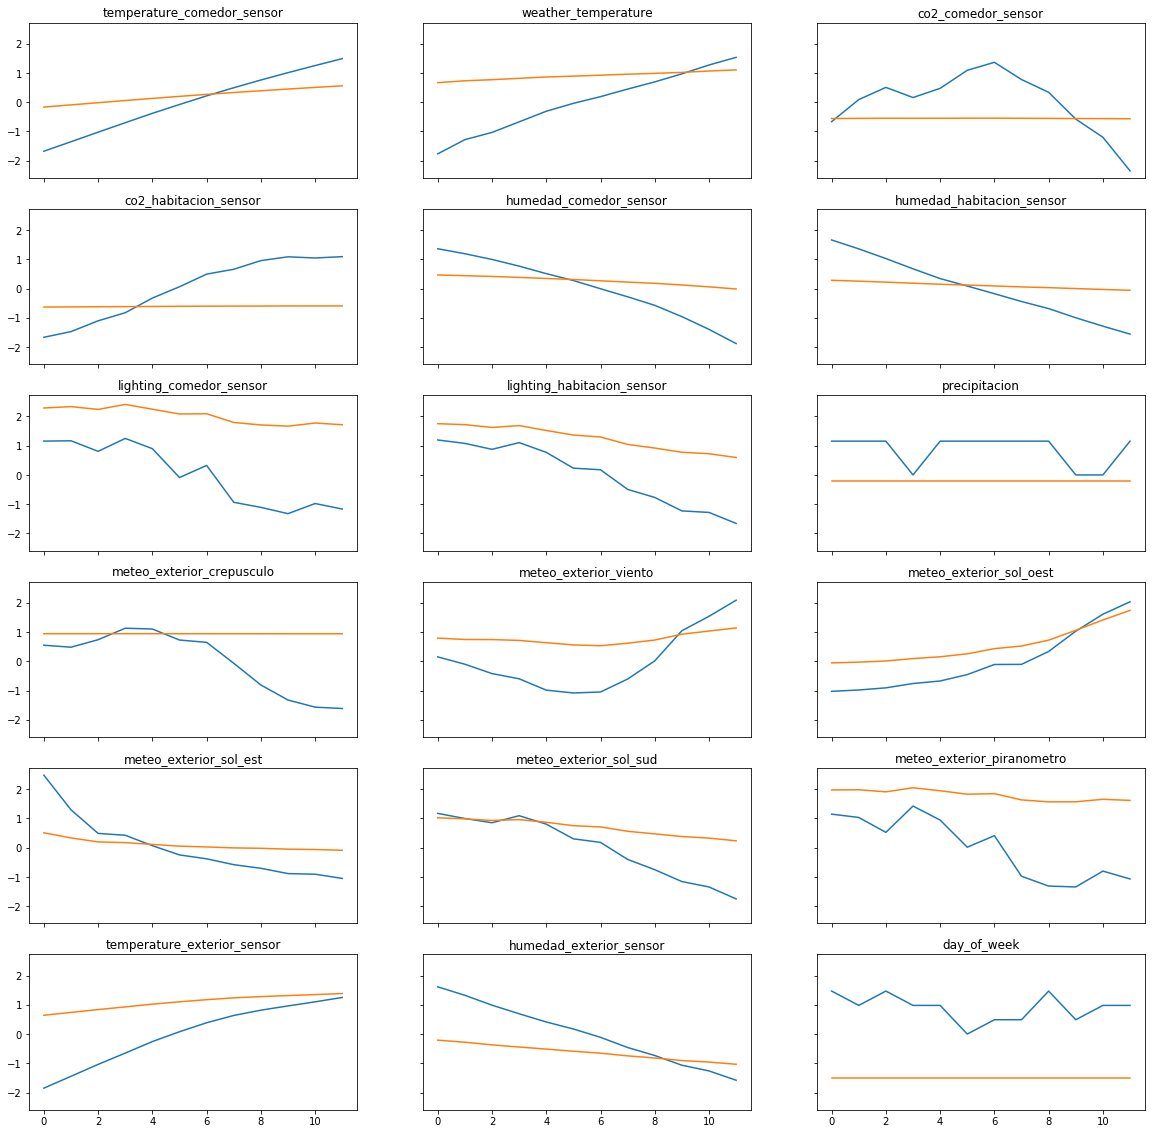

In [78]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(avg_c.shape[-1]), ax.flatten()):
    a.plot(avg_c[:, idx])
    a.plot(avg_c_true[:, idx])
    a.set_title(features[idx])


In [101]:
fig.savefig('input_attn_avg_batch.png')

In [102]:
avg_b = c_xs.mean(axis=0)

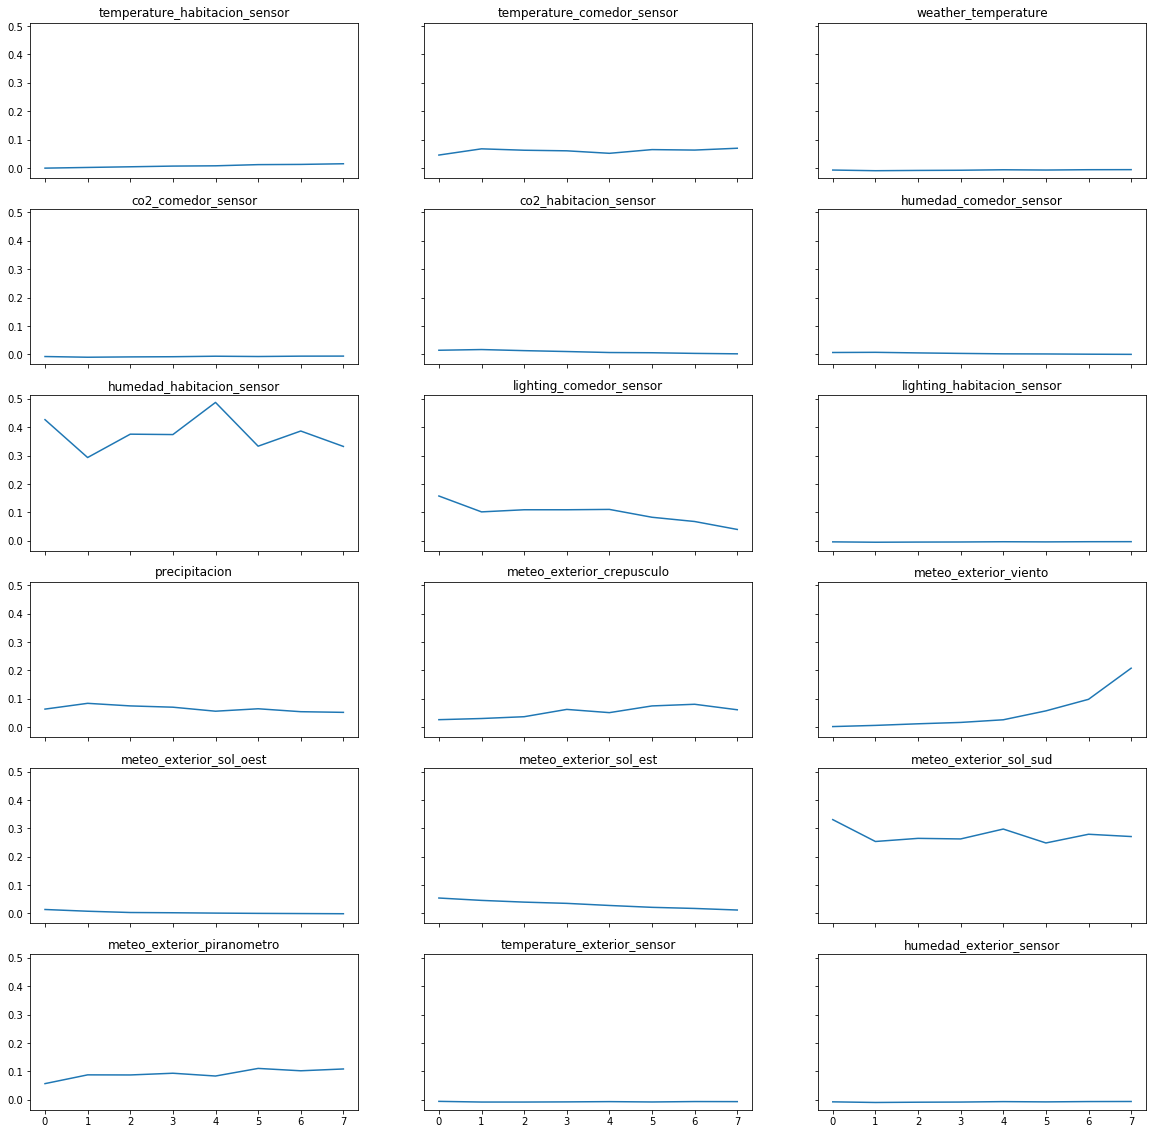

In [103]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(avg_b.shape[-1]), ax.flatten()):
    a.plot(avg_b[:, idx])
    a.set_title(features[idx])


In [104]:
fig.savefig('input_attn_avg_time')

In [113]:
full_series = c_xs.reshape((-1,len(features)))

In [114]:
t = (full_series - full_series.mean(axis=0)) / full_series.std(axis=0)

In [115]:
full_series_true = x_true.reshape((-1,len(features)))

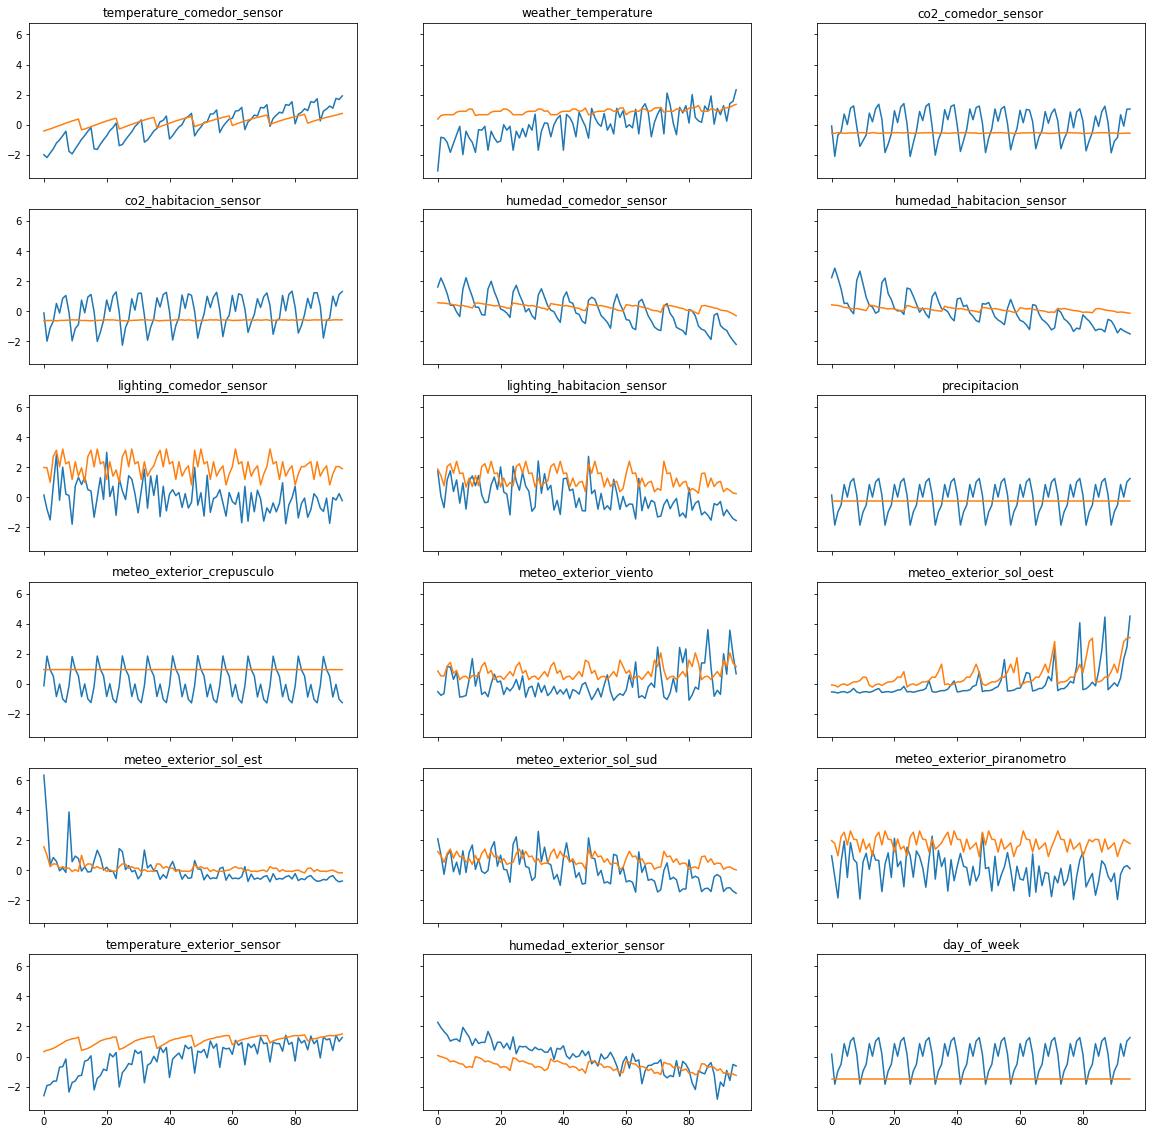

In [116]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(full_series.shape[-1]), ax.flatten()):
    a.plot(t[:, idx])
    a.plot(full_series_true[:, idx])
    a.set_title(features[idx])

In [118]:
fig.savefig('input_attn_full.png')